## Value Iteration & Policy Iteration
In this lab, we focus on the implementation and analysis of Value iteration and Policy iteration algorithms.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

rnd_state = np.random.RandomState(12)

## Problem setup and value function
We focus on GridWorld problem. Such problem consists in modelling with an MDP a grid in which each entry is a state

<img src="https://drive.google.com/uc?id=1v0f9ZdFQlA2-dAoWCZoV8iV-SksyXyUP" >

As we can observe from the example above, in Grid World problem generally there are one ore more final states with an associated reward. Given an arbitrary start state, we want to able to reach a final state by maximizing the cumulative reward. Actions are the directions in which we would like to move ("Up", "Down", "Left" and "Right"). Walls (i.e. the gray block in the example) are not states but can be interpreted as constraints that reduce  the amount of available action in near states, for instance, let $A(s)$ be the set of available action in state $s$, we have that in state $(1, 2)$, the action "Right" is not available i.e. 
$$
Right \not\in A((1,2))
$$
Stochastic information can be thought as the probability to perform an arbitrary (available) action (which differs from the one played).

We start by implementing a class representing the GridWorld problem

In [4]:
ACTIONS = ['Up', 'Down', 'Left', 'Right']
MOVES = {
    "Up" : (-1,0), 
    "Down" : (1, 0), 
    "Left" : (0,-1), 
    "Right" : (0, 1)
}

class Grid:
    
    def __init__(self, num_rows, num_columns, walls, end_states, rewards):
        self.num_rows = num_rows # number of rows
        self.num_columns = num_columns # number of columns
        self.walls = walls # list of walls (list of tuple)
        self.end_states = end_states # list of end states
        self.rewards = rewards # instant reward matrix
        assert self.rewards.shape[0] == self.num_rows and self.rewards.shape[1] == self.num_columns   

    # Given a state, it returns available actions i.e. A(s)
    def get_actions(self, r, c):
        # if the position (r, c) is an end state or a wall, returns empty list
        if (r, c) in self.end_states or (r, c) in self.walls:
            return []
        
        actions = []
        # TODO: according to the position (r, c), returns the list of available moves
        # moves are represented by strings ("Up", "Down", "Right", "Left")
        
        if r + 1 < self.num_rows and (r + 1, c) not in self.walls:
            actions.append("Down") 
        if r - 1 >= 0 and (r - 1, c) not in self.walls:
            actions.append("Up")
        if c + 1 < self.num_columns and (r, c + 1) not in self.walls:
            actions.append("Right")
        if c - 1 >= 0 and (r, c - 1) not in self.walls:
            actions.append("Left")
        
        
        return actions

    # Given a value function and an action, compute the value 
    def compute_V(self, V, action, state, gamma):
        other_actions = [act for act in self.get_actions(state[0], state[1]) if act != action]
        
        dr, dc = MOVES[action]
        next_state = (state[0] + dr, state[1] + dc)

        # TODO: compute the value function if there are no other actions
        Vs = self.rewards[state[0], state[1]] + gamma * V[next_state[0]][next_state[1]]
        

        
            
        return Vs

    
    # Visualization
    def printEnvironment(self, policy):
        res = ""
        for r in range(self.num_rows):
            res += "|"
            for c in range(self.num_columns):
                if (r, c) in self.walls:
                    val = "WALL"
                elif (r, c) in self.end_states:
                    val = "{}".format(self.rewards[r][c])
                else:
                    val = policy[r][c]
                res += " " + val[:5].ljust(5) + " |"
            res += "\n"
        print(res)
        
    


Example: we can instantiate a grid as follow

In [135]:

num_rows, num_columns = 4, 4
walls = [(1, 1), (2, 2)]

# Terminal states
end_states = [(0, 3), (1, 3)]

# Rewards
rewards = np.array([
    [0.0, 0.0, 0.0, 1], 
    [0.0, 0.0, 0.0, -1], 
    [0.0, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.0, 0.0]
]).reshape(num_rows, num_columns)

# Initialization of the grid
grid = Grid(num_rows, num_columns, walls=walls, end_states=end_states, rewards=rewards)

# Available actions in state (0, 0)
print("[--] s = (0, 0) => A(s) = {}".format(grid.get_actions(0,0)))

[--] s = (0, 0) => A(s) = ['Down', 'Right']


## Value Iteration
In this part of the lab, we focus on the implementation of Value Iteration algorithm. 

Value iteration is a method of computing an optimal policy for an MDP and its value. Value iteration starts at the end states and then works backward, refining an estimate of ${\cal V}^*$. 

Let ${\cal V}_k$ be the value function assuming there are k stages to go, we have
$$
{\cal V}_k(s) = \max\limits_{a \in A(s)} {\cal R}(s, a) + \gamma \sum\limits_{s' \in S}T^a_{ss'} {\cal V}_{k+1}(s')
$$
where ${\cal R}(s,a)$ is the reward obtained playing action $a$ in state $s$, $\gamma$ is the discount factor and $T^a_{s's}$ is the transition probability yo state $s'$ from state $s$ playing $a$.
Value iteration starts with a function ${\cal V}_0$ initialized with rewards $!=0$ only in end states. For subsequent stages, it uses the equation above the functions for k+1 stages to go from the functions for k stages to go.

In [136]:
def valueIteration(grid, tol=1e-5, discount=0.99):
    errors = []
    # Value function is initialized with instant rewards
    V = deepcopy(grid.rewards) 
    t = 0
    while True:
        next_V = np.zeros(V.shape, dtype=np.float64) + deepcopy(grid.rewards)
        error = 0
        for r in range(grid.num_rows):
            for c in range(grid.num_columns):
                # TODO: If the state (r, c) is an end state or a wall, skip it
                if (r, c) in grid.walls or (r, c) in grid.end_states:
                    continue
                # TODO: Perform Bellman update
                Vs = [grid.compute_V(V, action, (r, c), discount) for action in grid.get_actions(r, c)]
                # TODO: Update next_V[r, c]
                next_V[r, c] = max(Vs) 
                # TODO: eventually, update the maximum absolute error
                error = max(error, abs(next_V[r][c] - V[r][c]))
        V = next_V
        errors.append(error)
        if error < tol:
            print("[--] Converged at timestep {}".format(t))
            return V, errors, t
        t += 1


### Optimal value
Once the optimal value function has been estimated, we can obtain the optimal policy by choosing the actions that maximize that value function.

In [137]:
# Get the optimal policy from U
def getOptimalPolicy(grid, V):
    policy = grid.rewards.copy().astype(str)
    for r in range(grid.num_rows):
        for c in range(grid.num_columns):
            if (r, c) in grid.end_states or (r, c) in grid.walls:
                continue

            # TODO: Choose the action that maximizes the utility
            actions = grid.get_actions(r, c)
            utilities = []
            for action in actions:
                dr, dc = MOVES[action]
                utilities.append(V[r + dr ][c + dc])
                    
            
            best_action_idx = np.argmax(utilities)
            # TODO: Set the best action in the policy
            policy[r][c] = actions[best_action_idx]

    return np.asarray(policy).reshape(grid.num_rows, grid.num_columns)

Now, we can compute an optimal policy for the previous example

In [138]:
V, err, T = valueIteration(grid, tol=1e-1, discount=0.9)
opt_policy = getOptimalPolicy(grid, V)
grid.printEnvironment(opt_policy)

[--] Converged at timestep 10
| Right | Right | Right | 1.0   |
| Up    | WALL  | Up    | -1.0  |
| Up    | Left  | WALL  | Down  |
| Up    | Up    | Left  | Left  |



Text(0, 0.5, 'error')

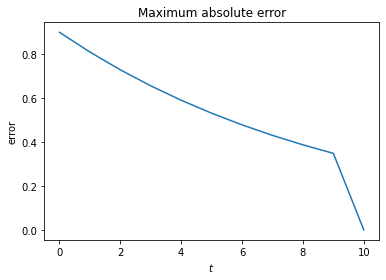

In [139]:
# Plot max error per iteration
fig, ax = plt.subplots()
ax.set_title("Maximum absolute error")
ax.plot(range(len(err)), err, '-')
ax.set_xlabel("$t$")
ax.set_ylabel("error")


In [140]:
# Print Value function after value iteration
print("[--] Value function: \n{}".format(V))

[--] Value function: 
[[ 0.729       0.81        0.9         1.        ]
 [ 0.6561      0.          0.81       -1.        ]
 [ 0.59049     0.531441    0.          0.34867844]
 [ 0.531441    0.4782969   0.43046721  0.38742049]]


Try different values for tolerance and discount factor and observe what changes


 ###  <font color="blueviolet">Analysis and Comments: <font color="navy">In this part I have tried different values for tolerance as well as discount factor for calculating discounted reward and below are my observation:

### <font color="navy"> For discoumt factor equal to 0.9 , 0.7 , 0.5 and 0.2 below are the plots:

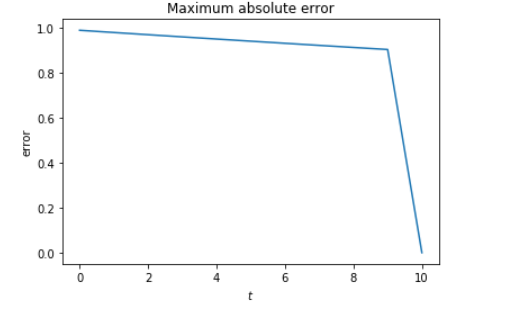

#### <center><font color="Navy"> discount factor = 0.9

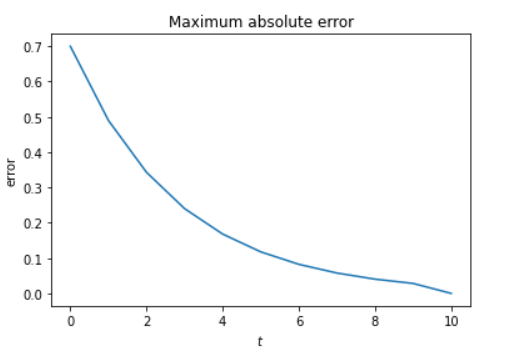

#### <center><font color="Navy"> discount factor = 0.7

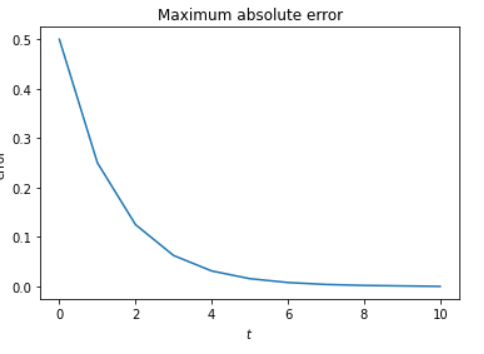

#### <center><font color="Navy"> discount factor = 0.5

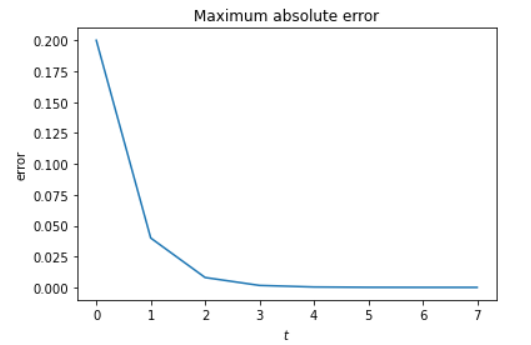

#### <center><font color="Navy"> discount factor = 0.2

### <font color="navy"> As it can be seen when we are giving a high discount factor to our model, it will start to reduce the error later in comparison with the cases that we have lower discount factor such as 0.2. When discount factor is 0.2 we can see that the plot start to fall very early almost is t=2. On the other hand for instance for discount factor=0.9, our model's error still the same until t=9 and from that point onwards we observe a very sharp reduction from 0.9 to nearly 0. So in my opinion if we have a lower discount factor our error have time to reduce gradually while for higher discount factor we remain in high errors for a long time and in the late stages this will begin to decrease.

## Policy Iteration
Now, we focus on implementing Policy Iteration algorithm. First we start by defining a function to generate random (valid) policies.

In [141]:
def generate_random_policy(grid):
    policy = grid.rewards.copy().astype(str)
    actions = []
    # TODO: generate a random policy (NB: actions must be available, i.e. NO illegal moves)
    for i in range(grid.num_rows):
        for j in range(grid.num_columns):
            
            actions = grid.get_actions(i,j)
            
            # ignore the state if no actions are available
            if len(actions) == 0:
                continue
            # select a random action
            policy[i][j] = actions[rnd_state.randint(0, len(actions))]
    return policy



Example: random policy

In [142]:
noise = 0.0

# Generate random policy
policy = generate_random_policy(grid)

# Print random policy on environment
print("Random policy is:\n")
grid.printEnvironment(policy)

Random policy is:

| Right | Left  | Left  | 1.0   |
| Up    | WALL  | Right | -1.0  |
| Right | Left  | WALL  | Up    |
| Up    | Up    | Right | Left  |



Policy iteration algorithm starts with a given random policy and iteratively improves it. Such procedure is based on two steps:
- policy evaluation: given a policy, we compute its value
- policy improvement: given a policy and its value, we perform an improvemetn


### Policy Evaluation
In the first step, given a policy, we want to compute its values. Thus, at time step $k$ given a deterministic policy $\pi_0(a|s) = a_0(s)$, we'll compute
$$
{\cal V}_{k+1}^{\pi_0}(s) = {\cal R}(s, a_0(s))) + \gamma \sum\limits_{s' \in S} T^{a_0(s)}_{ss'} {\cal V}_k(s')
$$

In [143]:
# Policy evaluation step: given a policy, it computes its value
def policyEvaluation(grid, policy, tol = 1e-5, discount=0.99):
    V = deepcopy(grid.rewards)
    while True:
        # get initial value for new utility function
        next_V = np.zeros(V.shape, dtype=np.float32) + deepcopy(grid.rewards)
        
        
        error = 0
        for r in range(grid.num_rows):
            for c in range(grid.num_columns):
                # TODO: if state (r, c) is a terminal state or a wall, skip it
                if (r, c) in grid.end_states or (r, c) in grid.walls:
                    continue

                # TODO: compute the utility value for (r, c) and 
                # max absolute error between new and old value functions

                next_V[r][c] = grid.compute_V(V, policy[r][c], (r, c), discount)
                error = max(error, abs(next_V[r][c]-V[r][c]))
        V = next_V
        # if the max absolute error is lower than a tolerance, returns the value function        
        if error < tol:
            return V 

        

Example: we can evaluate the random policy previously generated

In [144]:
V  = policyEvaluation(grid, policy, tol = 1e-5, discount=0.2)


print("Policy value: \n{}".format(V))

Policy value: 
[[ 0.   0.   0.   1. ]
 [ 0.   0.  -0.2 -1. ]
 [ 0.   0.   0.  -0.2]
 [ 0.   0.   0.   0. ]]


### Policy improvement
Now, we can implement Policy iteration algorithm by adding the policy improvement step. Given a deterministic policy $\pi_0$ and the corresponding value ${\cal V}^{\pi_0}$, compute a new deterministic policy $\pi (a | s) = a(s)$ as

$$
a(s) = \arg\max\limits_{a} {\cal R}(s, a) + \gamma \sum\limits_{s'} T^a_{ss'} {\cal V}^{\pi_0}(s')
$$

The algorithm stops when no improvement is performed i.e. 
$$
\pi(s) == \pi_0(s) \qquad \forall s \in S
$$ 

In [145]:
def policyIteration(grid, policy, tol, discount):
    t = 0
    while True:
        # TODO: Evaluate policy at time t
        V = policyEvaluation(grid, policy, tol = tol, discount=discount)
        unchanged = True 
        
        for r in range(grid.num_rows):
            for c in range(grid.num_columns):
                # TODO: if state is a wall or a terminal state, ignore it
                if (r, c) in grid.end_states or (r, c) in grid.walls:
                    continue
                
                # TODO: compute best action for state (r, c)
                actions = grid.get_actions(r, c)
                Vs = [grid.compute_V(V, action, (r, c), discount) for action in actions]
                
                idx_best = np.argmax(Vs)

                # TODO: if the value for best action of (r, c) is higher 
                # than the current value => update action
                if Vs[idx_best] > V[r][c] and actions[idx_best] != policy[r][c]:
                    policy[r][c] = actions[idx_best]
                    unchanged = False
        if unchanged:
            print("[--] Converged at timestep {}".format(t))
            return policy, V, t
        t += 1



Given a $4 \times 4$ grid and the following rewards:
$$
R = \begin{bmatrix}
0.0 & 0.0 & 0.0 & 1.0\\
0.0 & 0.0 & 0.0 & -1.0\\
0.0 & 0.0 & 0.0 & 0.0\\
0.0 & 0.0 & 0.0 & 0.0
\end{bmatrix}
$$
with two walls (in position $(1,1)$ and $(2,2)$) and with two end states (in position $(0, 3)$ and $(1,3)$). We run policy iteration to get an optimal policy. 

In [146]:
num_rows, num_columns = 4, 4
walls = [(1, 1), (2, 2)]

# Terminal states
end_states = [(0, 3), (1, 3)]

# Rewards
rewards = np.array([
    [0.0, 0.0, 0.0, 1], 
    [0.0, 0.0, 0.0, -1], 
    [0.0, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.0, 0.0]
]).reshape(num_rows, num_columns)

# Initialization of the grid
grid = Grid(num_rows, num_columns, walls=walls, end_states=end_states, rewards=rewards)

policy = generate_random_policy(grid)

opt_policy, opt_V, conv_t = policyIteration(grid, policy, tol=1e-5, discount=0.2)

[--] Converged at timestep 5


In [147]:
# Printing the optimal value function obtained with policy iteration
print("[--] Optimal Value function:\n", opt_V)

[--] Optimal Value function:
 [[ 8.00e-03  4.00e-02  2.00e-01  1.00e+00]
 [ 1.60e-03  0.00e+00  4.00e-02 -1.00e+00]
 [ 3.20e-04  6.40e-05  0.00e+00  0.00e+00]
 [ 6.40e-05  1.28e-05  2.56e-06  0.00e+00]]


In [148]:
# Printing the optimal policy obtained with policy iteration
print("The optimal policy is:\n")
grid.printEnvironment(opt_policy)

The optimal policy is:

| Right | Right | Right | 1.0   |
| Up    | WALL  | Up    | -1.0  |
| Up    | Left  | WALL  | Down  |
| Up    | Up    | Left  | Left  |



Text(0, 0.5, 'opt_V')

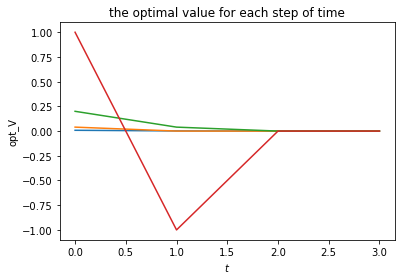

In [149]:
# Plot max error per iteration
fig, ax = plt.subplots()
ax.set_title("the optimal value for each step of time")
ax.plot(range(len(opt_V)), opt_V, '-')
ax.set_xlabel("$t$")
ax.set_ylabel("opt_V")


Now, change noise and discount factor and observe what changes

###  <font color="blueviolet">Analysis and Comments: <font color="navy"> First lets start with changing discount factor. Again similar to value itteration part I will give discount factor =0.9, 0.7 , 0.5 and 0.2 to my algorithm and below are related plots:

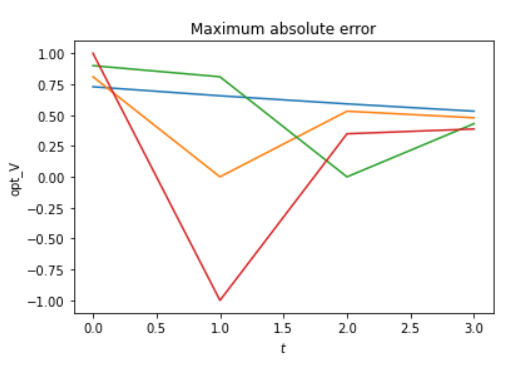

#### <center><font color="Navy"> discount factor = 0.9

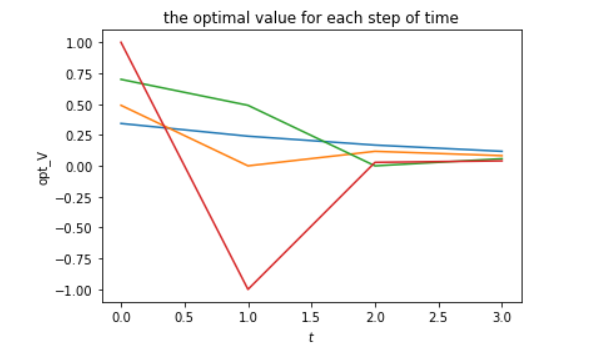

#### <center><font color="Navy"> discount factor = 0.7

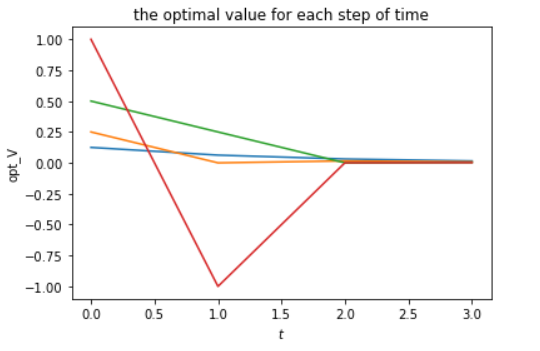

#### <center><font color="Navy"> discount factor = 0.5

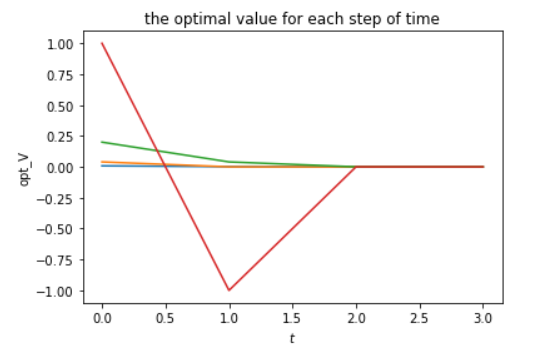

#### <center><font color="Navy"> discount factor = 0.2

###  <font color="blueviolet">Analysis and Comments: <font color="navy"> As you can see for policy itteration algorithm, we will need only 3 steps to reach the optimal policy. Meanwhile by changinvg the discount factor as it is evident from plots the optimal values are decreasing by reduction of this factor. Also we can see that are plots are giving 0 value by the end of 3th step whic is the desired result for showing that we arrived to the target.

In [150]:
num_rows, num_columns = 4, 4
walls = [(1, 1), (2, 2)]

# Terminal states
end_states = [(0, 3), (1, 3)]

# Rewards
rewards = np.array([
    [0.0, 0.0, 0.0, 1], 
    [0.0, 0.0, 0.0, -1], 
    [0.0, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.0, 0.0]
]).reshape(num_rows, num_columns)

discount = 0.99
tol = 1e-5

# Initialization of the grid
grid = Grid(num_rows, num_columns, walls=walls, end_states=end_states, rewards=rewards)

# TODO: run policy iteration and store the optimal policy and value function
policy = generate_random_policy(grid)

opt_policy, opt_V, conv_t = policyIteration(grid, policy, tol=tol, discount=discount)

print("[--] Policy obtained by Policy iteration:\n")
grid.printEnvironment(opt_policy)


# TODO: run value iteration and store the optimal policy and value function
V_vi, _, _ = valueIteration(grid, tol=1e-5, discount=0.99)
opt_policy_vi = getOptimalPolicy(grid, V_vi)

print("[--] Policy obtained by Value iteration:\n")
grid.printEnvironment(opt_policy_vi)


[--] Converged at timestep 5
[--] Policy obtained by Policy iteration:

| Right | Right | Right | 1.0   |
| Up    | WALL  | Up    | -1.0  |
| Up    | Left  | WALL  | Down  |
| Up    | Up    | Left  | Left  |

[--] Converged at timestep 10
[--] Policy obtained by Value iteration:

| Right | Right | Right | 1.0   |
| Up    | WALL  | Up    | -1.0  |
| Up    | Left  | WALL  | Down  |
| Up    | Up    | Left  | Left  |



In [151]:
# TODO: Evaluate policies obtained and compare them
eval_opt_pol = policyEvaluation(grid, opt_policy, tol=1e-5)
eval_pol_vi = policyEvaluation(grid, opt_policy_vi, tol=1e-5)

print("[--] Are optimal policies (PI and VI) equivalent? {}\n".format(np.allclose(eval_opt_pol, eval_pol_vi)))



[--] Are optimal policies (PI and VI) equivalent? True



**Discuss here the result obtained and the differences of PI and VI:**

###  <font color="blueviolet">Analysis and Comments: <font color="navy"> In policy iteration, we start with a fixed policy. while, in value iteration, we begin by selecting the value function. Then, in both algorithms, we iteratively improve until we reach optimal policy.

### <font color="navy">The policy iteration algorithm updates the policy. The value iteration algorithm iterates over the value function instead. but, both algorithms implicitly update the policy and state value function in each iteration.

### <font color="navy">In each iteration, the policy iteration function goes through two phases. One phase evaluates the policy, and the other one improves it.The value iteration algorithm  combines two phases of the policy iteration into a single update operation. However, the value iteration function runs through all possible actions at once to find the maximum action value. Subsequently, the value iteration algorithm is computationally heavier.
 
### <font color="navy"> The most obvious difference for me was the steps that they took to reach the result which was fewer for policy itteration.